# Light Guide Panel Generator

Light Guide Panels are the (literal) backbone of LCD screen illumination.
They're the diffusion secret sauce behind uniformly backlit LCD displays.
When illuminated from the edge, they illuminate outwards through the pattern etched on the surface of the arylic.

It turns out that design software for this sort of thing [already exists](https://www.febees.com/index.html). But why pay \$1500 when we can write a crude version that will do the job?

In [93]:
#%matplotlib inline
import matplotlib.pyplot as plt
import drawSvg as draw
import numpy as np
from scipy.optimize import curve_fit
from ipywidgets import interactive
from IPython.display import SVG, display, HTML
import base64


# Extra fn for rescaling displayed SVGs
_html_template='<img width="{}" src="data:image/svg+xml;base64,{}" >'

# def svg_to_fixed_width_html_image(svg, width="100%"):
#     text = _html_template.format(width, base64.b64encode(svg))
#     return HTML(text)

def svg_to_fixed_width_html_image(svg, width="50%"):
    b64 = base64.b64encode(svg).decode("utf8")
    text = f'<img width="{width}" src="data:image/svg+xml;base64,{b64}" >'
    return HTML(text) 

In [88]:
half_width_mm = 8.5*25.4 / 2
height_mm = 14 * 25.4

In [175]:
import scipy.interpolate as interpolate

def spline_gen(x1, y1, x2, y2, x3, y3):
    half_width = half_width_mm
    x = np.array([0, x1, x2, x3, half_width])
    y = np.array([0, y1, y2, y3, half_width])
    t, c, k = interpolate.splrep(x, y, s=0, k=3)
    N = 100
    xmin, xmax = x.min(), x.max()
    xx = np.linspace(xmin, xmax, N)
    spline = interpolate.BSpline(t, c, k, extrapolate=False)
    plt.axes().set_aspect('equal')
    plt.plot(x, y, 'bo', label='Control Points')
    plt.plot(x,x, '-')
    plt.plot(xx, spline(xx), 'r', label='BSpline')
    plt.grid()
    plt.legend(loc='best')
    plt.title("Half Length Illumination Density")
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()
    return t,c,k


w = interactive(spline_gen,
                x1=(0,half_width_mm, 0.25), 
                y1=(0, half_width_mm, 0.25), 
                x2=(0,half_width_mm,0.25),
                y2=(0, half_width_mm, 0.25), 
                x3=(0, half_width_mm, 0.25), 
                y3=(0, half_width_mm, 0.25))
display(w)

interactive(children=(FloatSlider(value=53.75, description='x1', max=107.94999999999999, step=0.25), FloatSlid…

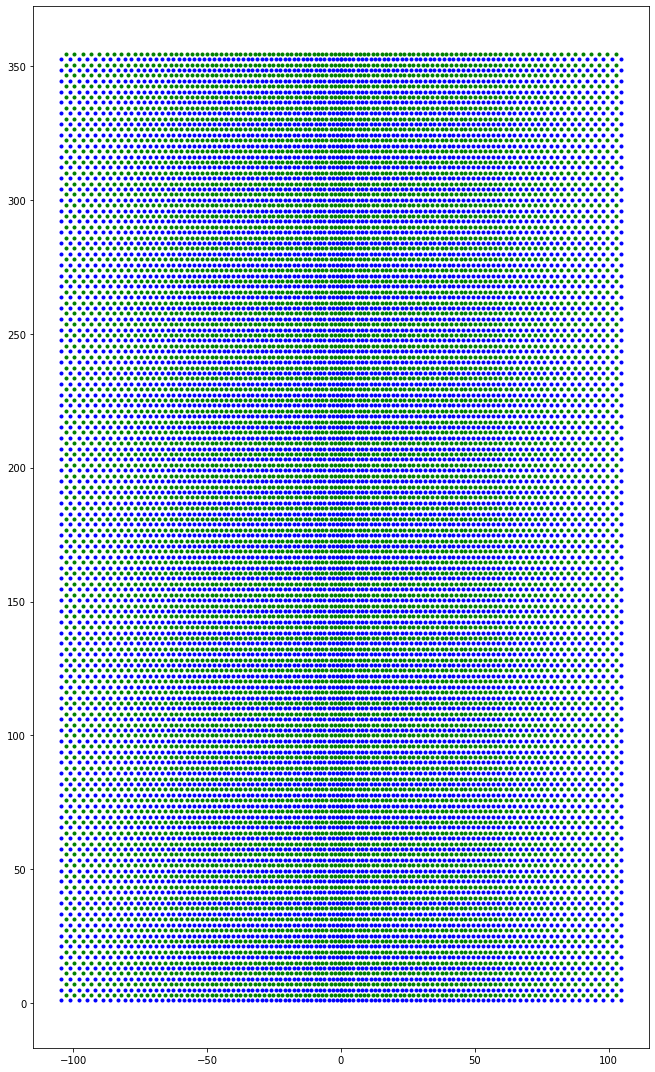

In [210]:
height = height_mm
width = half_width_mm
nominal_spacing = 2

num_xpts = round((width - nominal_spacing)/float(nominal_spacing))
num_ypts = round((height - nominal_spacing)/float(nominal_spacing))

spline = interpolate.BSpline(*w.result, extrapolate=False)

Y = np.linspace(0, height, round(num_ypts/2), endpoint=False)
Xnom = np.linspace(0, width, num_xpts, endpoint=False)
X = spline(Xnom)
xx, yy = np.meshgrid(X, Y)

yoffset = (Y[1] - Y[0])/2.
xoffset = (Xnom[1] - Xnom[0])/2.
Y2 = np.linspace(yoffset, height + yoffset, round(num_ypts/2), endpoint=False)#[:-1]
X2nom = np.linspace(xoffset, width + xoffset, num_xpts, endpoint=False)[:-1]
X2 = spline(X2nom)
xx2, yy2 = np.meshgrid(X2,Y2)

# Move non-illuminated sides off the top/bottom edge.
yy += nominal_spacing/2.
yy2 += nominal_spacing/2.

# TODO: we need to renormalize the output since it has been stretched beyond the width of the original img.

# Plot:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.plot(xx, yy, ls="None", marker=".", color="blue")
ax.plot(xx2, yy2, ls="None", marker=".", color="green")
ax.plot(-xx, yy, ls="None", marker=".", color="blue")
ax.plot(-xx2, yy2, ls="None", marker=".", color="green")
plt.tight_layout()
plt.show()

In [213]:
# Create an SVG replacing the two meshgrids from above with actual circles.

offset = (10, 10)
d = draw.Drawing(2*half_width_mm + 2*offset[0], height_mm + 2*offset[0],
                 origin=(-half_width_mm - offset[0], 0),
                 displayInline=False)
r = draw.Rectangle(-half_width_mm,0, 2*half_width_mm, height_mm, fill='#ffffff',
                   stroke='#ff00ff', stroke_width="1")
d.append(r)
# Produce the circle pattern.
for xx, yy in [[xx, yy], [xx2, yy2], [-xx, yy], [-xx2, yy2]]:
    for x,y in zip(xx.flatten(), yy.flatten()):
        c = draw.Circle(x, y, r=0.5, stroke_width='0.1', stroke='black',
                        fill_opacity=1.0)#, id='circle')
        d.append(c)
d.saveSvg('example.svg')

In [214]:
#display(SVG(url='https://upload.wikimedia.org/wikipedia/commons/f/f6/People_%28example%29.svg'))
svg_to_fixed_width_html_image(SVG('example.svg').data.encode('ascii'), width="50%")